# Sanity Check of FedLeak, Lung & Colon Cancer (LC25000)

Here is the sanity check on if FedLeak has been correctly trasferred.

We evaluate it with ***Lung & Colon Cancer (LC25000)***, with $5$ times sampling batch = $16$, reporting the best results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from train-set, with `shuffle=True`.
- *Way to report*: PSNRs in $5$ times recovery, including the *max* value and the *median* value.

Codes are aligned with `sanity_check_showcase.ipynb`, with `generator.py` introduced.

### 🚩 1. Utils Importing

In [1]:
# ⚠️ WARNING:
# ⚠️ Here we make a monkey patch for tqdm, removing the progress bar of training in consoles.
# ⚠️ Since it would make the output of cell very messy if we run it with `run_notebook.py`.
# ⚠️ 
# ⚠️ Set `need_tqdm_monkey_patch` as `False` to forbid this behaviour, especially when you
# ⚠️ directly run this jupyter notebook, rather than executing with `run_notebook.py`.
need_tqdm_monkey_patch = True
if need_tqdm_monkey_patch:
    import tqdm
    _real_tqdm = tqdm.tqdm

    def _silent_tqdm(*args, **kwargs):
        kwargs["disable"] = True
        return _real_tqdm(*args, **kwargs)

    tqdm.tqdm = _silent_tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [3]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:3")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128))
])

dataset = torchvision.datasets.ImageFolder(root="~/data/lung_colon_image_set/", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, generator=torch.Generator().manual_seed(seed))
loader_iter = iter(trainloader)

device

device(type='cuda', index=3)

### 🚩 3. Attack for five times

In [4]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

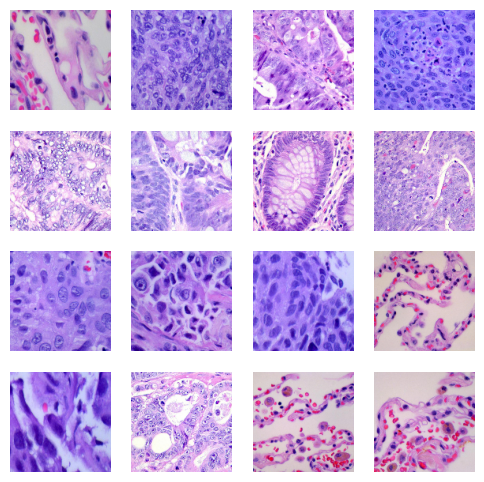

| It: 1 | Loss: -16.7143 | Time:   5.38s |


| It: 1001 | Loss: -61.1567 | Time: 562.94s |


| It: 2001 | Loss: -61.5967 | Time: 564.86s |


| It: 3001 | Loss: -61.7056 | Time: 563.56s |


| It: 4001 | Loss: -61.7732 | Time: 565.62s |


| It: 5001 | Loss: -61.8145 | Time: 562.70s |


| It: 6001 | Loss: -61.8490 | Time: 565.06s |


| It: 7001 | Loss: -61.8742 | Time: 564.30s |


| It: 8001 | Loss: -61.8896 | Time: 565.63s |


| It: 9001 | Loss: -61.8979 | Time: 563.79s |


| It: 1 | Loss: -18.0446 | Time:   0.61s |


| It: 1001 | Loss: -60.7913 | Time: 565.10s |


| It: 2001 | Loss: -61.4858 | Time: 563.78s |


| It: 3001 | Loss: -61.6465 | Time: 563.99s |


| It: 4001 | Loss: -61.7392 | Time: 563.20s |


| It: 5001 | Loss: -61.7934 | Time: 562.17s |


| It: 6001 | Loss: -61.8328 | Time: 562.92s |


| It: 7001 | Loss: -61.8617 | Time: 562.06s |


| It: 8001 | Loss: -61.8803 | Time: 563.30s |


| It: 9001 | Loss: -61.8889 | Time: 562.59s |


| It: 1 | Loss: -25.7884 | Time:   0.41s |


| It: 1001 | Loss: -61.2231 | Time: 562.43s |


| It: 2001 | Loss: -61.6162 | Time: 563.21s |


| It: 3001 | Loss: -61.7190 | Time: 563.00s |


| It: 4001 | Loss: -61.7817 | Time: 562.30s |


| It: 5001 | Loss: -61.8223 | Time: 562.47s |


| It: 6001 | Loss: -61.8556 | Time: 563.40s |


| It: 7001 | Loss: -61.8788 | Time: 559.64s |


| It: 8001 | Loss: -61.8946 | Time: 563.70s |


| It: 9001 | Loss: -61.9029 | Time: 563.64s |


| It: 1 | Loss: -31.7691 | Time:   0.46s |


| It: 1001 | Loss: -60.9620 | Time: 563.82s |


| It: 2001 | Loss: -61.5454 | Time: 562.49s |


| It: 3001 | Loss: -61.7023 | Time: 563.85s |


| It: 4001 | Loss: -61.7694 | Time: 565.77s |


| It: 5001 | Loss: -61.8190 | Time: 564.60s |


| It: 6001 | Loss: -61.8493 | Time: 562.85s |


| It: 7001 | Loss: -61.8756 | Time: 561.78s |


| It: 8001 | Loss: -61.8919 | Time: 562.09s |


| It: 9001 | Loss: -61.9001 | Time: 565.90s |


| It: 1 | Loss: -18.0656 | Time:   0.55s |


| It: 1001 | Loss: -60.9411 | Time: 561.46s |


| It: 2001 | Loss: -61.5009 | Time: 563.96s |


| It: 3001 | Loss: -61.6778 | Time: 562.23s |


| It: 4001 | Loss: -61.7446 | Time: 565.03s |


| It: 5001 | Loss: -61.7997 | Time: 565.10s |


| It: 6001 | Loss: -61.8379 | Time: 565.15s |


| It: 7001 | Loss: -61.8676 | Time: 562.12s |


| It: 8001 | Loss: -61.8861 | Time: 565.41s |


| It: 9001 | Loss: -61.8949 | Time: 563.21s |


BEST PSNR: 14.7103
MEDIAN PSNR: 14.2063
ALL PSNR: [14.6194, 14.1246, 14.7103, 12.9139, 12.9139]


<Figure size 400x300 with 0 Axes>

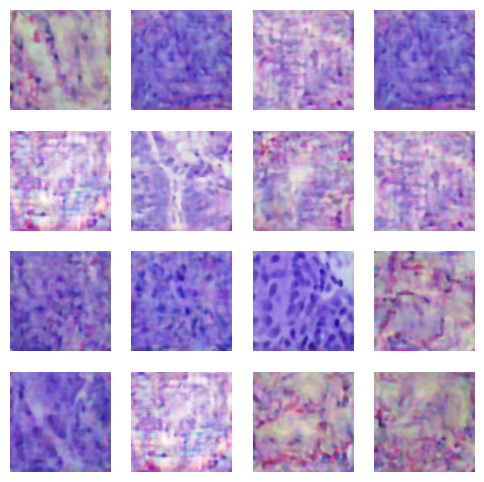

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

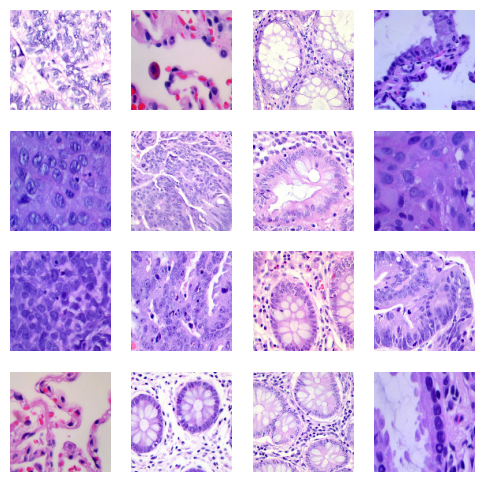

| It: 1 | Loss: -28.7953 | Time:   0.51s |


| It: 1001 | Loss: -60.8336 | Time: 560.73s |


| It: 2001 | Loss: -61.4740 | Time: 562.85s |


| It: 3001 | Loss: -61.6410 | Time: 561.19s |


| It: 4001 | Loss: -61.7234 | Time: 562.02s |


| It: 5001 | Loss: -61.7736 | Time: 564.98s |


| It: 6001 | Loss: -61.8184 | Time: 564.42s |


| It: 7001 | Loss: -61.8484 | Time: 564.07s |


| It: 8001 | Loss: -61.8685 | Time: 565.12s |


| It: 9001 | Loss: -61.8784 | Time: 564.96s |


| It: 1 | Loss: -19.1514 | Time:   0.39s |


| It: 1001 | Loss: -60.6783 | Time: 352.33s |


| It: 2001 | Loss: -61.3420 | Time: 353.73s |


| It: 3001 | Loss: -61.5635 | Time: 350.40s |


| It: 4001 | Loss: -61.6834 | Time: 352.62s |


| It: 5001 | Loss: -61.7534 | Time: 354.21s |


| It: 6001 | Loss: -61.8043 | Time: 352.20s |


| It: 7001 | Loss: -61.8416 | Time: 353.58s |


| It: 8001 | Loss: -61.8651 | Time: 355.77s |


| It: 9001 | Loss: -61.8759 | Time: 354.96s |


| It: 1 | Loss: -17.7527 | Time:   0.37s |


| It: 1001 | Loss: -60.9342 | Time: 352.39s |


| It: 2001 | Loss: -61.4558 | Time: 348.33s |


| It: 3001 | Loss: -61.6329 | Time: 354.87s |


| It: 4001 | Loss: -61.7190 | Time: 352.02s |


| It: 5001 | Loss: -61.7733 | Time: 352.27s |


| It: 6001 | Loss: -61.8184 | Time: 352.87s |


| It: 7001 | Loss: -61.8483 | Time: 352.12s |


| It: 8001 | Loss: -61.8688 | Time: 352.06s |


| It: 9001 | Loss: -61.8800 | Time: 352.15s |


| It: 1 | Loss: -25.9893 | Time:   0.39s |


| It: 1001 | Loss: -60.9050 | Time: 353.02s |


| It: 2001 | Loss: -61.4939 | Time: 350.79s |


| It: 3001 | Loss: -61.6481 | Time: 351.84s |


| It: 4001 | Loss: -61.7291 | Time: 351.91s |


| It: 5001 | Loss: -61.7826 | Time: 344.19s |


| It: 6001 | Loss: -61.8251 | Time: 351.84s |


| It: 7001 | Loss: -61.8560 | Time: 352.93s |


| It: 8001 | Loss: -61.8752 | Time: 341.80s |


| It: 9001 | Loss: -61.8856 | Time: 351.78s |


| It: 1 | Loss: -28.0128 | Time:   0.39s |


| It: 1001 | Loss: -60.7936 | Time: 352.91s |


| It: 2001 | Loss: -61.4518 | Time: 351.67s |


| It: 3001 | Loss: -61.6238 | Time: 350.14s |


| It: 4001 | Loss: -61.7103 | Time: 343.42s |


| It: 5001 | Loss: -61.7692 | Time: 352.19s |


| It: 6001 | Loss: -61.8152 | Time: 348.18s |


| It: 7001 | Loss: -61.8466 | Time: 350.75s |


| It: 8001 | Loss: -61.8682 | Time: 351.33s |


| It: 9001 | Loss: -61.8789 | Time: 350.48s |


BEST PSNR: 13.5418
MEDIAN PSNR: 13.0685
ALL PSNR: [12.7056, 12.6203, 13.0144, 13.5418, 13.5418]


<Figure size 400x300 with 0 Axes>

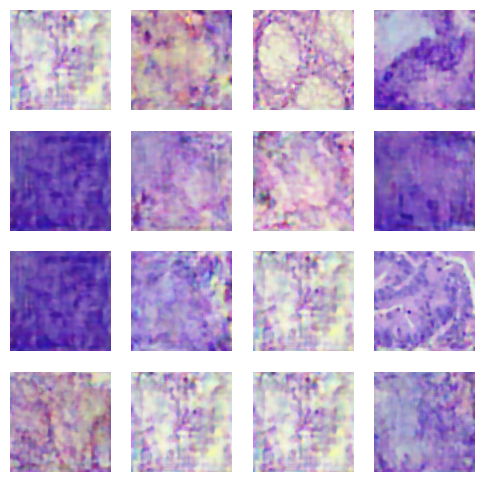

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

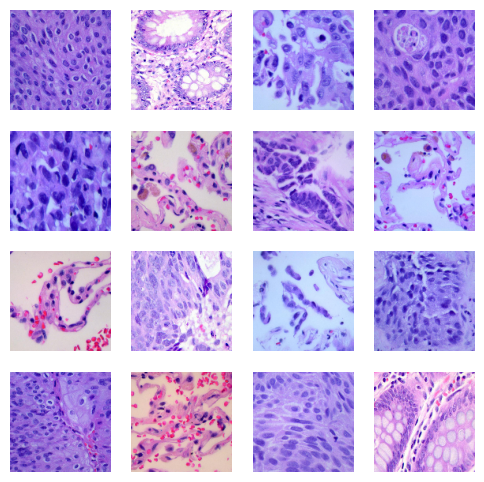

| It: 1 | Loss: -12.1161 | Time:   0.33s |


| It: 1001 | Loss: -60.8771 | Time: 350.11s |


| It: 2001 | Loss: -61.5249 | Time: 350.36s |


| It: 3001 | Loss: -61.6805 | Time: 351.79s |


| It: 4001 | Loss: -61.7536 | Time: 349.94s |


| It: 5001 | Loss: -61.8007 | Time: 350.28s |


| It: 6001 | Loss: -61.8361 | Time: 350.56s |


| It: 7001 | Loss: -61.8629 | Time: 349.82s |


| It: 8001 | Loss: -61.8807 | Time: 349.79s |


| It: 9001 | Loss: -61.8884 | Time: 351.66s |


| It: 1 | Loss: -13.0190 | Time:   0.39s |


| It: 1001 | Loss: -60.9389 | Time: 348.68s |


| It: 2001 | Loss: -61.5631 | Time: 349.98s |


| It: 3001 | Loss: -61.7000 | Time: 341.73s |


| It: 4001 | Loss: -61.7646 | Time: 344.71s |


| It: 5001 | Loss: -61.8113 | Time: 346.21s |


| It: 6001 | Loss: -61.8435 | Time: 352.03s |


| It: 7001 | Loss: -61.8688 | Time: 353.48s |


| It: 8001 | Loss: -61.8850 | Time: 354.72s |


| It: 9001 | Loss: -61.8931 | Time: 349.47s |


| It: 1 | Loss: -15.3435 | Time:   0.38s |


| It: 1001 | Loss: -60.3343 | Time: 354.43s |


| It: 2001 | Loss: -61.3983 | Time: 354.17s |


| It: 3001 | Loss: -61.6020 | Time: 358.78s |


| It: 4001 | Loss: -61.7116 | Time: 363.81s |


| It: 5001 | Loss: -61.7717 | Time: 366.27s |


| It: 6001 | Loss: -61.8136 | Time: 364.13s |


| It: 7001 | Loss: -61.8470 | Time: 362.39s |


| It: 8001 | Loss: -61.8684 | Time: 364.17s |


| It: 9001 | Loss: -61.8781 | Time: 365.97s |


| It: 1 | Loss: -27.4890 | Time:   0.41s |


| It: 1001 | Loss: -60.9457 | Time: 357.38s |


| It: 2001 | Loss: -61.5248 | Time: 359.23s |


| It: 3001 | Loss: -61.6838 | Time: 359.76s |


| It: 4001 | Loss: -61.7462 | Time: 360.37s |


| It: 5001 | Loss: -61.7981 | Time: 359.74s |


| It: 6001 | Loss: -61.8321 | Time: 358.90s |


| It: 7001 | Loss: -61.8603 | Time: 359.50s |


| It: 8001 | Loss: -61.8770 | Time: 359.24s |


| It: 9001 | Loss: -61.8859 | Time: 358.91s |


| It: 1 | Loss: -21.1625 | Time:   0.39s |


| It: 1001 | Loss: -60.4575 | Time: 358.90s |


| It: 2001 | Loss: -61.2761 | Time: 359.48s |


| It: 3001 | Loss: -61.5006 | Time: 356.99s |


| It: 4001 | Loss: -61.6169 | Time: 358.95s |


| It: 5001 | Loss: -61.6875 | Time: 360.01s |


| It: 6001 | Loss: -61.7397 | Time: 357.90s |


| It: 7001 | Loss: -61.7790 | Time: 358.20s |


| It: 8001 | Loss: -61.8042 | Time: 358.72s |


| It: 9001 | Loss: -61.8164 | Time: 360.05s |


BEST PSNR: 13.6067
MEDIAN PSNR: 12.9773
ALL PSNR: [13.2189, 13.6067, 12.3591, 12.9150, 12.9150]


<Figure size 400x300 with 0 Axes>

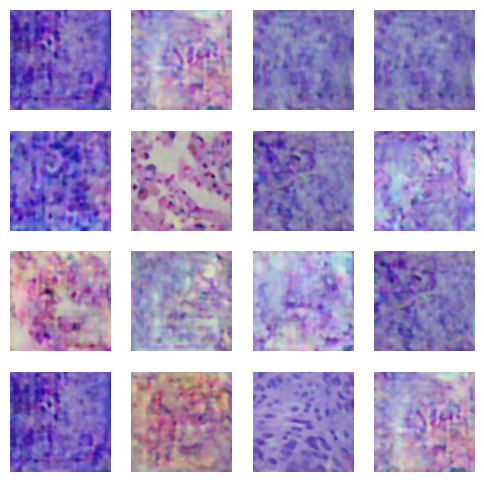

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

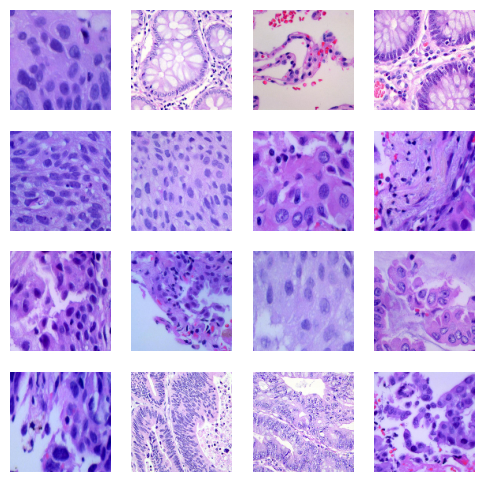

| It: 1 | Loss: -21.3736 | Time:   0.34s |


| It: 1001 | Loss: -60.7628 | Time: 358.61s |


| It: 2001 | Loss: -61.3760 | Time: 358.34s |


| It: 3001 | Loss: -61.5482 | Time: 356.98s |


| It: 4001 | Loss: -61.6422 | Time: 355.44s |


| It: 5001 | Loss: -61.7070 | Time: 355.74s |


| It: 6001 | Loss: -61.7527 | Time: 355.20s |


| It: 7001 | Loss: -61.7912 | Time: 356.13s |


| It: 8001 | Loss: -61.8149 | Time: 356.18s |


| It: 9001 | Loss: -61.8286 | Time: 357.72s |


| It: 1 | Loss: -37.2633 | Time:   0.35s |


| It: 1001 | Loss: -60.4012 | Time: 359.67s |


| It: 2001 | Loss: -61.2545 | Time: 359.80s |


| It: 3001 | Loss: -61.4830 | Time: 359.01s |


| It: 4001 | Loss: -61.6092 | Time: 353.83s |


| It: 5001 | Loss: -61.6955 | Time: 358.66s |


| It: 6001 | Loss: -61.7580 | Time: 353.62s |


| It: 7001 | Loss: -61.8062 | Time: 359.16s |


| It: 8001 | Loss: -61.8396 | Time: 358.16s |


| It: 9001 | Loss: -61.8561 | Time: 358.62s |


| It: 1 | Loss: -4.8631 | Time:   0.37s |


| It: 1001 | Loss: -60.9688 | Time: 358.63s |


| It: 2001 | Loss: -61.4666 | Time: 355.01s |


| It: 3001 | Loss: -61.6379 | Time: 358.81s |


| It: 4001 | Loss: -61.7295 | Time: 353.13s |


| It: 5001 | Loss: -61.7881 | Time: 355.40s |


| It: 6001 | Loss: -61.8315 | Time: 357.51s |


| It: 7001 | Loss: -61.8626 | Time: 359.58s |


| It: 8001 | Loss: -61.8813 | Time: 353.13s |


| It: 9001 | Loss: -61.8906 | Time: 355.58s |


| It: 1 | Loss: -33.1042 | Time:   0.36s |


| It: 1001 | Loss: -60.8704 | Time: 358.79s |


| It: 2001 | Loss: -61.4799 | Time: 358.77s |


| It: 3001 | Loss: -61.6516 | Time: 359.83s |


| It: 4001 | Loss: -61.7380 | Time: 359.91s |


| It: 5001 | Loss: -61.7881 | Time: 358.28s |


| It: 6001 | Loss: -61.8299 | Time: 356.49s |


| It: 7001 | Loss: -61.8605 | Time: 357.84s |


| It: 8001 | Loss: -61.8810 | Time: 359.44s |


| It: 9001 | Loss: -61.8900 | Time: 359.23s |


| It: 1 | Loss: -25.8587 | Time:   0.39s |


| It: 1001 | Loss: -60.9247 | Time: 352.90s |


| It: 2001 | Loss: -61.4529 | Time: 355.84s |


| It: 3001 | Loss: -61.6414 | Time: 356.32s |


| It: 4001 | Loss: -61.7337 | Time: 357.84s |


| It: 5001 | Loss: -61.7890 | Time: 359.20s |


| It: 6001 | Loss: -61.8309 | Time: 358.54s |


| It: 7001 | Loss: -61.8616 | Time: 360.33s |


| It: 8001 | Loss: -61.8805 | Time: 359.10s |


| It: 9001 | Loss: -61.8907 | Time: 355.12s |


BEST PSNR: 14.8851
MEDIAN PSNR: 13.5323
ALL PSNR: [13.3220, 13.3986, 13.0056, 13.0499, 13.0499]


<Figure size 400x300 with 0 Axes>

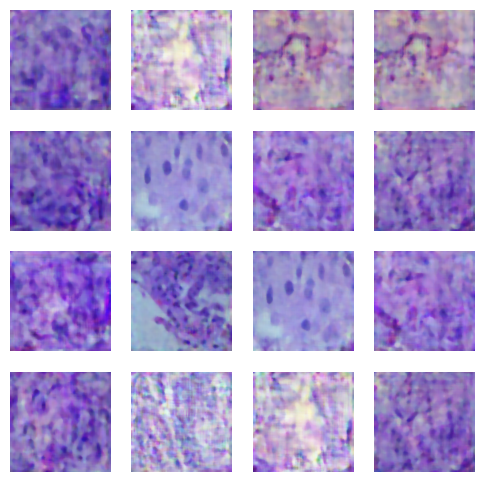

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

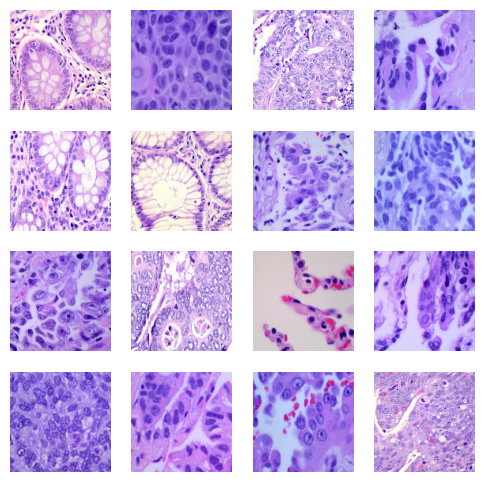

| It: 1 | Loss: -26.8207 | Time:   0.35s |


| It: 1001 | Loss: -61.3318 | Time: 359.33s |


| It: 2001 | Loss: -61.6840 | Time: 358.79s |


| It: 3001 | Loss: -61.7665 | Time: 358.51s |


| It: 4001 | Loss: -61.8182 | Time: 358.73s |


| It: 5001 | Loss: -61.8488 | Time: 359.17s |


| It: 6001 | Loss: -61.8738 | Time: 358.90s |


| It: 7001 | Loss: -61.8941 | Time: 359.21s |


| It: 8001 | Loss: -61.9058 | Time: 359.24s |


| It: 9001 | Loss: -61.9124 | Time: 358.87s |


| It: 1 | Loss: -27.0695 | Time:   0.35s |


| It: 1001 | Loss: -61.1172 | Time: 352.76s |


| It: 2001 | Loss: -61.6023 | Time: 358.62s |


| It: 3001 | Loss: -61.7241 | Time: 358.69s |


| It: 4001 | Loss: -61.7846 | Time: 356.68s |


| It: 5001 | Loss: -61.8278 | Time: 351.52s |


| It: 6001 | Loss: -61.8565 | Time: 359.25s |


| It: 7001 | Loss: -61.8804 | Time: 352.88s |


| It: 8001 | Loss: -61.8954 | Time: 356.86s |


| It: 9001 | Loss: -61.9026 | Time: 359.58s |


| It: 1 | Loss: -19.8415 | Time:   0.36s |


| It: 1001 | Loss: -61.3183 | Time: 360.43s |


| It: 2001 | Loss: -61.6620 | Time: 359.46s |


| It: 3001 | Loss: -61.7494 | Time: 360.68s |


| It: 4001 | Loss: -61.8061 | Time: 347.15s |


| It: 5001 | Loss: -61.8444 | Time: 339.93s |


| It: 6001 | Loss: -61.8696 | Time: 338.04s |


| It: 7001 | Loss: -61.8897 | Time: 340.21s |


| It: 8001 | Loss: -61.9029 | Time: 338.11s |


| It: 9001 | Loss: -61.9096 | Time: 336.27s |


| It: 1 | Loss: -28.9617 | Time:   0.27s |


| It: 1001 | Loss: -60.9937 | Time: 338.00s |


| It: 2001 | Loss: -61.6234 | Time: 338.31s |


| It: 3001 | Loss: -61.7422 | Time: 340.48s |


| It: 4001 | Loss: -61.7928 | Time: 330.83s |


| It: 5001 | Loss: -61.8350 | Time: 339.75s |


| It: 6001 | Loss: -61.8647 | Time: 341.32s |


| It: 7001 | Loss: -61.8856 | Time: 338.58s |


| It: 8001 | Loss: -61.8993 | Time: 334.00s |


| It: 9001 | Loss: -61.9060 | Time: 340.19s |


| It: 1 | Loss: -21.3541 | Time:   0.33s |


| It: 1001 | Loss: -61.2317 | Time: 338.51s |


| It: 2001 | Loss: -61.6371 | Time: 338.22s |


| It: 3001 | Loss: -61.7439 | Time: 335.23s |


| It: 4001 | Loss: -61.8000 | Time: 339.65s |


| It: 5001 | Loss: -61.8321 | Time: 339.39s |


| It: 6001 | Loss: -61.8645 | Time: 338.50s |


| It: 7001 | Loss: -61.8842 | Time: 339.51s |


| It: 8001 | Loss: -61.8985 | Time: 337.68s |


| It: 9001 | Loss: -61.9049 | Time: 338.76s |


BEST PSNR: 15.1403
MEDIAN PSNR: 14.3249
ALL PSNR: [14.0325, 14.1879, 15.1403, 14.3500, 14.3500]


<Figure size 400x300 with 0 Axes>

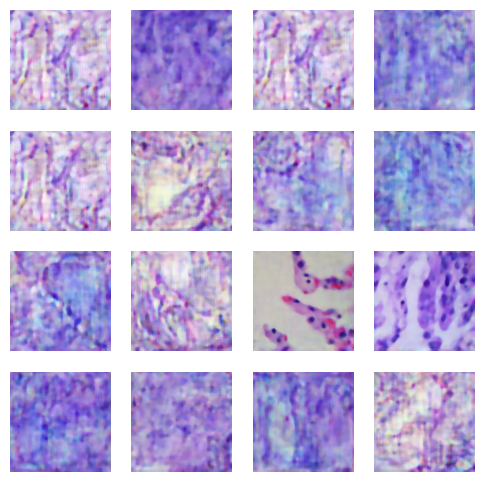

In [9]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)